In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [ ]:
import ktrain
from ktrain import text
from sklearn.model_selection import train_test_split

In [8]:
import pickle #for saving output files, pickles
from sys import stdout
import time #for time.sleep function to delay calls
from tqdm import tqdm #for updating loop
#from os import listdir
#from os.path import isfile, join
import glob #pattern matching and expansion.

In [3]:
#get all pickle files from folder into a list, 'picks'
picks = sorted(glob.glob("/home/russell/Documents/DataScience/DonorsChoose/Data/Metrics_100/*pickle")) 

In [18]:
#this will create a master list with the same # of elements as projects
basic_list = []
for pf in picks:
    #https://stackoverflow.com/a/3249684/1602288
    stdout.write("\r%s" % pf)
    stdout.flush()
    basic_list.append(pickle.load(open(pf,"rb")))
    #basic_list = basic_list+(pickle.load(open(picks[0],"rb")))
    #sleep(.4)
stdout.write("\n")

/home/russell/Documents/DataScience/DonorsChoose/Data/Metrics_100/pickle_100.pickle


In [50]:
bigframe = pd.concat(basic_list)

In [51]:
bigframe.shape

(5050, 38)

In [62]:
ok = bigframe.astype(str).drop_duplicates() #drop duplicate rows

In [66]:
pd.set_option('display.max_columns', None)
#d.set_option("max_rows", None) #undo by resetting --- pd.reset_option(“max_rows”)

In [67]:
ok.head(4)

,id,proposalURL,fundURL,imageURL,retinaImageURL,thumbImageURL,fulfillmentTrailer,percentFunded,numDonors,costToComplete,studentLed,numStudents,professionalDevelopment,distanceLearningProject,totalPrice,freeShipping,teacherId,teacherName,teacherTypes,schoolTypes,schoolName,schoolUrl,city,zip,state,stateFullName,latitude,longitude,expirationDate,expirationTime,fundingStatus,fullyFundedDate,waitingForCheckPayment,modifiedDate,shortDescription,matchingfund,grade_level,poverty_level
0,4956615,https://www.donorschoose.org/project/razkids-f...,https://secure.donorschoose.org/donors/givingC...,https://www.donorschoose.org/teacher/photo/u45...,https://www.donorschoose.org/teacher/photo/u45...,https://www.donorschoose.org/teacher/photo/u45...,Help me give my students a summer reading boos...,100,5,0.00,False,22,False,False,181.91,true,4549537,Mrs. Andersen,"[{'id': 9, 'name': 'NEA member'}]","[{'id': 3, 'name': 'Special Education'}]",McKinley Elementary School,https://www.donorschoose.org/school/mckinley-e...,Fairfield,06825-4349,CT,Connecticut,41.179460000000000,-73.236553000000000,2020-10-01,1601524800000,funded,"Tuesday, June 2, 2020 9:37:03 PM EDT",false,"Wednesday, June 3, 2020 12:00:00 AM EDT",My school is a Title I school with many intern...,no,Grades PreK-2,MODERATELOW
0,4904116,https://www.donorschoose.org/project/math-dice...,https://secure.donorschoose.org/donors/givingC...,https://www.donorschoose.org/teacher/photo/u67...,https://www.donorschoose.org/teacher/photo/u67...,https://www.donorschoose.org/teacher/photo/u67...,Help me give my students various dice and a st...,100,4,0.00,False,16,False,True,328.12,false,6780495,Ms. S,"[{'id': 5, 'name': 'SONIC Teacher'}]","[{'id': 12, 'name': 'Horace Mann (partner)'}]",Newton Elementary School,https://www.donorschoose.org/school/newton-sch...,Greenfield,01301-2108,MA,Massachusetts,42.586375000000000,-72.614923000000000,2020-09-08,1599537600000,funded,"Thursday, May 14, 2020 9:57:57 PM EDT",false,"Wednesday, June 3, 2020 12:00:00 AM EDT","The coronavirus has completely altered what ""n...",no,Grades 3-5,HIGHEST
0,4333875,https://www.donorschoose.org/project/creating-...,https://secure.donorschoose.org/donors/givingC...,https://www.donorschoose.org/teacher/photo/u66...,https://www.donorschoose.org/teacher/photo/u66...,https://www.donorschoose.org/teacher/photo/u66...,"Help me give my students a safe, welcoming, co...",100,13,0.00,False,20,False,False,854.54,true,6609741,Ms. Emma Goodwin,[],"[{'id': 12, 'name': 'Horace Mann (partner)'}]",Edison K-8 School,https://www.donorschoose.org/school/edison-k-8...,Brighton,02135-3130,MA,Massachusetts,42.345333000000000,-71.160202000000000,2019-12-09,1575867600000,funded,"Wednesday, August 14, 2019 1:07:23 AM EDT",false,"Wednesday, June 3, 2020 12:00:00 AM EDT","This year, I will begin my teaching career as ...",no,Grades 3-5,HIGHEST
0,4948217,https://www.donorschoose.org/project/all-kids-...,https://secure.donorschoose.org/donors/givingC...,https://www.donorschoose.org/teacher/photo/u71...,https://www.donorschoose.org/teacher/photo/u71...,https://www.donorschoose.org/teacher/photo/u71...,Help me give my students basic school supplies...,100,10,0.00,False,15,False,True,924.20,true,7196579,Ms. K. Azer,[],"[{'id': 8, 'name': 'New Leaders'}]",Williamsburg Preparatory School,https://www.donorschoose.org/school/williamsbu...,Brooklyn,11211-3324,NY,New York,40.715492300000001,-73.955039799999994,2020-09-27,1601179200000,funded,"Tuesday, June 2, 2020 9:31:25 PM EDT",false,"Wednesday, June 3, 2020 12:00:00 AM EDT",Our school sits in the heart of the now-gentri...,no,Grades 9-12,HIGHEST


In [64]:
trailers =ok['fulfillmentTrailer']

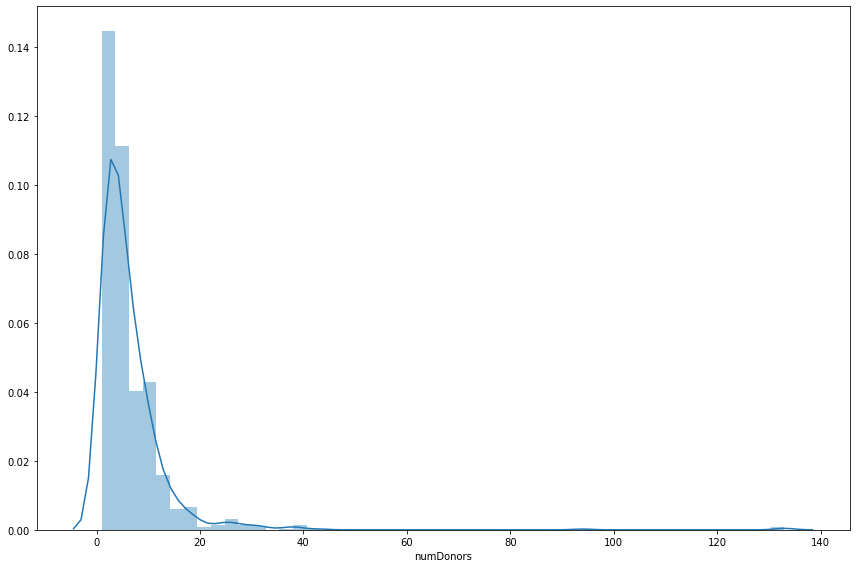

In [74]:

fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(ok["numDonors"].dropna())
fig.tight_layout()

In [54]:
nodups = bigframe.loc[bigframe.astype(str).drop_duplicates().index]

In [55]:
nodups.shape

(10221200, 38)

In [47]:
bigframe['fulfillmentTrailer'].value_counts()

Help me give my students diverse books so they can continue reading while the library is closed.                                                  15
Help me give my students four complete dorm bedding sets for their dorm.                                                                          10
Help me give my students access to toiletries and personal hygiene supplies during this trying time!                                              10
Help me give my students reading and math puzzles to reinforce academic skills at home.                                                            6
Help me give my students a choice of a book to have at home to read over the summer.                                                               6
                                                                                                                                                  ..
Help me give my students tools to better organize our classroom and to learn with.                        

In [49]:
bigframe['id'].value_counts()

4929501    6
4933742    6
4931239    6
4925749    6
4951112    6
          ..
4933779    1
4812087    1
4808455    1
4823130    1
4684083    1
Name: id, Length: 1044, dtype: int64

In [46]:
f_trailers = bigframe['fulfillmentTrailer'].array
print(f_trailers)

<PandasArray>
[                                                                                       'Help me give my students a summer reading boost with a very engaging digital reading program.',
                                       'Help me give my students various dice and a starting dice game to use in endless ways at home to practice, reinforce, and learn math concepts.',
                                                              'Help me give my students a safe, welcoming, comfortable classroom space where they can feel at home and ready to learn!',
                                      'Help me give my students basic school supplies!  Every child needs a pencil and now even disinfectant wipes to keep everyone safe and learning!',
                           'Help me give my students the hands on materials they need during Remote learning! I have included hands on materials as well as a math workbook and snack.',
                                                             

In [38]:
type(what)

pandas.core.series.Series

In [37]:
len(what)

5050

In [40]:
w_a = what.array

In [41]:
len(w_a)

5050

In [42]:
w_a[0]

'Help me give my students a summer reading boost with a very engaging digital reading program.'

In [44]:
for b in range(10):
    #print(b)
    print(bigframe['fulfillmentTrailer'].array[b])
    


Help me give my students a summer reading boost with a very engaging digital reading program.
Help me give my students various dice and a starting dice game to use in endless ways at home to practice, reinforce, and learn math concepts.
Help me give my students a safe, welcoming, comfortable classroom space where they can feel at home and ready to learn!
Help me give my students basic school supplies!  Every child needs a pencil and now even disinfectant wipes to keep everyone safe and learning!
Help me give my students the hands on materials they need during Remote learning! I have included hands on materials as well as a math workbook and snack.
Help me give my students a comfortable, social distance reading corner with mobile seats and individual book bins!
Help me give my students summer skill workbooks and playing cards for math games to continue distance learning.
I need one virtual Get Your Teach On admission and a teacher planner.
Help me give my students these books which are 

In [300]:
bigframe['proposalURL'].value_counts()

https://www.donorschoose.org/project/non-fiction-for-curious-minds/4225892/               4
https://www.donorschoose.org/project/soft-starts-to-increase-focus/4630880/               4
https://www.donorschoose.org/project/new-fossil-plate-kits-for-students-to-ex/4957790/    4
https://www.donorschoose.org/project/putting-it-all-together/4947967/                     4
https://www.donorschoose.org/project/sports-for-physical-education/4873326/               4
https://www.donorschoose.org/project/curious-minds-love-stem-science-the-hum/4890556/     4
https://www.donorschoose.org/project/feeling-all-the-feelings-make-social-e/4510532/      4
https://www.donorschoose.org/project/tools-to-help-expand-creativity/4270556/             4
https://www.donorschoose.org/project/magic-of-music/4661625/                              4
https://www.donorschoose.org/project/super-sensory-walk/4843498/                          4
https://www.donorschoose.org/project/new-athletic-uniforms-for-middle-school/495

In [186]:
checkdf = pd.DataFrame(project_IDs,columns =['proj_id'])
checkdf
pd.set_option("max_rows", None) #undo by resetting --- pd.reset_option(“max_rows”)
checkdf

,proj_id
0,4770461
1,4822073
2,4912619
3,4873150
4,4904035
5,4908254
6,4890517
7,4955536
8,4937550
9,4915416


In [182]:
checkdf['proj_id'].value_counts()

4885359    4
4918039    4
4879853    4
4764841    4
4956913    4
4475625    4
4947668    4
4908254    4
4945703    4
4770584    4
4732489    4
4904035    4
4902361    4
4953575    4
4944722    4
4949899    4
4948100    4
4943826    4
4796421    4
4320160    4
4955536    4
4814839    4
4939356    4
4621985    4
4904970    4
4947428    4
4931271    4
4654114    4
4915416    4
4947119    4
4912619    4
4806437    4
4167102    4
4935614    4
4770461    4
4879494    4
4880636    4
4161759    4
4535151    4
4525325    4
4873150    4
4759273    4
4408750    4
4937550    4
4822073    4
4944540    4
4664368    4
4811184    4
4890517    4
4805579    4
Name: proj_id, dtype: int64

In [166]:
basic_list[0]

{'id': '4770461', 'proposalURL': 'https://www.donorschoose.org/project/inspiring-students/4770461/', 'fundURL': 'https://secure.donorschoose.org/donors/givingCart.html?proposalid=4770461&donationAmount=45', 'imageURL': 'https://www.donorschoose.org/teacher/photo/u3690019?size=sm&t=1532720007365', 'retinaImageURL': 'https://www.donorschoose.org/teacher/photo/u3690019?size=retina&t=1532720007365', 'thumbImageURL': 'https://www.donorschoose.org/teacher/photo/u3690019?size=thmb&t=1532720007365', 'title': 'Inspiring Students', 'shortDescription': 'Teaching first grade brings joy to me each day. My students come from a variety of backgrounds in West Philadelphia. These backgrounds melt together when we are in class because we are able to...', 'fulfillmentTrailer': 'Help me give my students Reading Rods, ink cartridges, hand sanitizer, and more.', 'snippets': [], 'percentFunded': '100', 'numDonors': '3', 'costToComplete': '0.00', 'studentLed': False, 'numStudents': '30', 'professionalDevelopm

In [147]:
bewild = pd.DataFrame.from_dict(lookat)

ValueError: arrays must all be same length

In [45]:
import json
from bs4 import BeautifulSoup

In [46]:
import scrapy
#modified scrapy settings here:
#/home/russell/anaconda3/envs/insight/lib/python3.8/site-packages/scrapy/settings
#to include the user agents described here: https://www.scrapehero.com/how-to-fake-and-rotate-user-agents-using-python-3/

In [47]:
df = pd.read_csv("/home/russell/Downloads/opendata_projects.csv", thousands = ',')
pd.set_option('display.max_columns', None)
#pd.set_option("max_rows", None) #undo by resetting --- pd.reset_option(“max_rows”)bb

In [101]:
current = "https://www.donorschoose.org/common/json_feed.html?showFacetCounts=true&APIKey=H9v7hCeN&max=100&index=0"
historical = "https://www.donorschoose.org/common/json_feed.html?showFacetCounts=true&APIKey=H9v7hCeN&max=40&historical=true&index=0"


In [102]:
r = requests.get(historical)
data_dict = json.loads(r.text)

In [72]:
print(data_dict)

{'searchTerms': 'Most urgent', 'searchURL': 'https://www.donorschoose.org/donors/search.html?historical=true', 'searchVOHashCode': 1547686084, 'totalProposals': '1674618', 'index': '0', 'max': '50', 'breadcrumb': [['max', '100', ''], ['historical', 'true', 'Completed']], 'proposals': [{'id': '4944919', 'proposalURL': 'https://www.donorschoose.org/project/help-care-for-me-at-home-please/4944919/', 'fundURL': 'https://secure.donorschoose.org/donors/givingCart.html?proposalid=4944919&donationAmount=45', 'imageURL': 'https://www.donorschoose.org/teacher/photo/u1616220?size=sm&t=1394165327649', 'retinaImageURL': 'https://www.donorschoose.org/teacher/photo/u1616220?size=retina&t=1394165327649', 'thumbImageURL': 'https://www.donorschoose.org/teacher/photo/u1616220?size=thmb&t=1394165327649', 'title': 'Help Care For Me At Home Please', 'shortDescription': 'My students are the best inner-city kids. Throughout this whole pandemic, I have slowly watched them lose their smiles and become depressed

In [98]:
for key in data_dict.items():
    print (key)

('searchTerms', 'Most urgent')
('searchURL', 'https://www.donorschoose.org/donors/search.html?historical=true')
('searchVOHashCode', 1547686084)
('totalProposals', '1674619')
('index', '0')
('max', '50')
('breadcrumb', [['max', '100', ''], ['historical', 'true', 'Completed']])
('proposals', [{'id': '4890670', 'proposalURL': 'https://www.donorschoose.org/project/writing-in-colors-from-the-distance/4890670/', 'fundURL': 'https://secure.donorschoose.org/donors/givingCart.html?proposalid=4890670&donationAmount=45', 'imageURL': 'https://www.donorschoose.org/teacher/photo/u326209?size=sm&t=1533943300307', 'retinaImageURL': 'https://www.donorschoose.org/teacher/photo/u326209?size=retina&t=1533943300307', 'thumbImageURL': 'https://www.donorschoose.org/teacher/photo/u326209?size=thmb&t=1533943300307', 'title': 'Writing In Colors From The Distance', 'shortDescription': 'My students have been out of school since mid March. We left on spring break and never returned. We did not know we were not re

In [103]:
dicts_on_this_page = list(data_dict.values())

proposal_ind = ([list(data_dict.keys()).index('proposals')])[0]  #

proposal_list = dicts_on_this_page[proposal_ind]
#dicts_on_this_page[proposal_ind]
#proposal_ind = which(data.keys()=='proposals')
#print(proposal_ind)
#print(proposals_on_this_page[7])

In [116]:
proposal_list[0]

{'id': '4928948', 'proposalURL': 'https://www.donorschoose.org/project/distance-learning-reading-and-math-educ/4928948/', 'fundURL': 'https://secure.donorschoose.org/donors/givingCart.html?proposalid=4928948&donationAmount=45', 'imageURL': 'https://www.donorschoose.org/teacher/photo/u1016971?size=sm&t=1325728301000', 'retinaImageURL': 'https://www.donorschoose.org/teacher/photo/u1016971?size=retina&t=1325728301000', 'thumbImageURL': 'https://www.donorschoose.org/teacher/photo/u1016971?size=thmb&t=1325728301000', 'title': 'Distance Learning Reading and Math- Education Is Essential!', 'shortDescription': 'My students are the most creative, active, and hard working learners. Many of them come from low-income homes and lack the resources they need to be successful. They have family members working on...', 'fulfillmentTrailer': 'Help me give my students math manipulatives and materials, books, and writing workbooks to help them at home.', 'snippets': [], 'percentFunded': '100', 'numDonors':

In [112]:
first_proposal = proposal_list[0] #returns dictionary of first proposal items

In [113]:
type(first_proposal)

<class 'dict'>

In [95]:
for key in first_proposal.items():
    print (key)

('id', '4944919')
('proposalURL', 'https://www.donorschoose.org/project/help-care-for-me-at-home-please/4944919/')
('fundURL', 'https://secure.donorschoose.org/donors/givingCart.html?proposalid=4944919&donationAmount=45')
('imageURL', 'https://www.donorschoose.org/teacher/photo/u1616220?size=sm&t=1394165327649')
('retinaImageURL', 'https://www.donorschoose.org/teacher/photo/u1616220?size=retina&t=1394165327649')
('thumbImageURL', 'https://www.donorschoose.org/teacher/photo/u1616220?size=thmb&t=1394165327649')
('title', 'Help Care For Me At Home Please')
('shortDescription', 'My students are the best inner-city kids. Throughout this whole pandemic, I have slowly watched them lose their smiles and become depressed. They miss school, and they miss their friends. I want...')
('fulfillmentTrailer', 'Help me give my students hygiene items and healthier snacks for their homes.')
('snippets', [])
('percentFunded', '100')
('numDonors', '2')
('costToComplete', '0.00')
('studentLed', False)
('num

In [44]:
print(soup)

{
  "searchTerms": "Most urgent",
  "searchURL": "https://www.donorschoose.org/donors/search.html?historical=true",
  "searchVOHashCode": 1547686084,
  "totalProposals": "1674603",
  "index": "0",
  "max": "50",
  "breadcrumb": [
    [
      "max",
      "100",
      ""
    ],
    [
      "historical",
      "true",
      "Completed"
    ]
  ],
  "proposals": [
    {
      "id": "4855975",
      "proposalURL": "https://www.donorschoose.org/project/books-to-keep-students-reading-during-co/4855975/",
      "fundURL": "https://secure.donorschoose.org/donors/givingCart.html?proposalid=4855975&amp;donationAmount=45",
      "imageURL": "https://www.donorschoose.org/teacher/photo/u11668?size=sm&amp;t=1545428762141",
      "retinaImageURL": "https://www.donorschoose.org/teacher/photo/u11668?size=retina&amp;t=1545428762141",
      "thumbImageURL": "https://www.donorschoose.org/teacher/photo/u11668?size=thmb&amp;t=1545428762141",
      "title": "Books to Keep Students Reading During Covid-19 Cri

# _DRAW OUT SCREENS and FUNCTIONALITY GOALS FOR END OF WEEK_



## MONDAY
    Well scoped, clearly-defined problem + some data
## 	TUESDAY
    SQL[organized data] 
## 	WED 
    analytics/working algo/some results ----> (python linked to sql data)
## 	THUR – SQL mapped to PYTHON connected to FLASK (or something)


# GOOD Qs to ASK SELF AND OTHERS
#### 	-What’s actionable about your product?
#### 	-Did you try other models?
#### 	-Is this better than random?
#### 	-Is this better than the simplest model?
#### 	-Why did you choose these inputs?
#### 	-How did you validate this?
#### 	-What are your metrics for success?
#### 	-What are the assumptions of your model?
#### 	-How would you improve this project with more time?

In [3]:
df.shape

(1203287, 44)

In [4]:
df.head()

,_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,"""teacher_ny_teaching_fellow""",primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,vendor_shipping_charges,sales_tax,payment_processing_charges,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration
0,7342bd01a2a7725ce033a179d22e382d,5c43ef5eac0f5857c266baa1ccfa3d3f,9e72d6f2f1e9367b578b6479aa5852b7,3.600097e+11,40.688454,-73.910432,New York City,NY,11207.0,urban,New York City Dept Of Ed,Kings (Brooklyn),f,t,f,f,f,f,Mr.,f,f,Other,Applied Learning,NaN,NaN,Supplies,highest poverty,Grades 6-8,NaN,NaN,NaN,NaN,229.0,279.27,0.0,251.9,1,f,f,completed,2002-09-13 00:00:00,2002-09-23 00:00:00,2003-01-27 00:00:00,2003-12-31 00:00:00
1,ed87d61cef7fda668ae70be7e0c6cebf,1f4493b3d3fe4a611f3f4d21a249376a,1ae4695be589a36816188e2b301a0395,3.600077e+11,40.765517,-73.960090,New York City,NY,10065.0,NaN,New York City Dept Of Ed,New York (Manhattan),f,f,f,f,f,f,Ms.,f,f,Literacy,Literacy & Language,NaN,NaN,Books,highest poverty,Grades 9-12,NaN,NaN,NaN,NaN,125.0,152.44,0.0,137.0,1,f,f,completed,2002-09-13 00:00:00,2002-09-23 00:00:00,2003-01-03 00:00:00,2003-12-31 00:00:00
2,b56b502d25666e29550d107bf7e17910,57426949b47700ccf62098e1e9b0220c,4a06a328dd87bd29892d73310052f45f,3.600077e+11,40.770233,-73.950760,New York City,NY,10075.0,NaN,New York City Dept Of Ed,New York (Manhattan),f,t,f,f,f,f,Ms.,f,f,Early Development,Applied Learning,NaN,NaN,Supplies,moderate poverty,Grades 3-5,NaN,NaN,NaN,NaN,125.0,152.44,0.0,125.0,1,f,f,completed,2002-09-16 00:00:00,2002-09-19 00:00:00,2002-12-19 00:00:00,2003-12-31 00:00:00
3,016f03312995d5c89d6b348be4682166,9c0aa56b63b743454d6da9effcf122fc,bb0af5dac1b54693ba86ef63eacd6594,3.600076e+11,40.727826,-73.978721,New York City,NY,10009.0,urban,New York City Dept Of Ed,New York (Manhattan),f,f,f,f,f,f,Ms.,f,f,History & Geography,History & Civics,NaN,NaN,Supplies,high poverty,Grades PreK-2,NaN,NaN,NaN,NaN,187.0,228.05,0.0,205.0,1,f,f,completed,2002-09-17 00:00:00,2002-09-17 00:00:00,2002-12-02 00:00:00,2003-12-31 00:00:00
4,cf6275558534ca1b276b0d8d5130dd9a,1d4d8a42730dbb66af1ebb6ab37456b7,768dab263f87881fe7c68ffb3965df7c,3.600083e+11,40.841216,-73.938605,New York City,NY,10032.0,urban,New York City Dept Of Ed,New York (Manhattan),f,f,f,f,f,f,Ms.,t,f,Other,Applied Learning,NaN,NaN,Supplies,highest poverty,Grades PreK-2,NaN,NaN,NaN,NaN,240.0,292.68,0.0,264.0,1,f,f,completed,2002-09-17 00:00:00,2002-09-23 00:00:00,2003-02-26 00:00:00,2003-12-31 00:00:00


In [5]:
df.columns

Index(['_projectid', '_teacher_acctid', '_schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', ' "teacher_ny_teaching_fellow"',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'vendor_shipping_charges', 'sales_tax',
       'payment_processing_charges', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'total_donations', 'num_donors', 'eligible_double_your_impact_match',
       'eligible_almost_home_match', 'funding_status', 'date_posted',
       'date_complet

In [18]:
df['primary_focus_area'].value_counts()

Literacy & Language    508084
Math & Science         326323
Music & The Arts       105410
Applied Learning        80312
Special Needs           78884
Health & Sports         53519
History & Civics        50709
Name: primary_focus_area, dtype: int64

In [16]:
expired = df[(df['funding_status']=='expired')]

In [17]:
df['_teacher_acctid'].value_counts()

fa2f220b537e8653fb48878ebb38044d    370
a006826c170f91f85ff80dc5a132fade    361
02bccf5c109ace4f3dcbce819a46daa1    349
9d7051e2611cebdb758f1c7bd09360ac    316
9f49ba20aa1c28eb95dbad8b8edd2b69    316
                                   ... 
899ce20468db07d649a58e38a25ed55d      1
266bd98ea7e71bf1fbad5a0dd8ec69f0      1
afc712b464db278714755cee218caad2      1
f10ae341471a4cb05db7d90c7fb82301      1
43569fe13dc7c6c827213a5c2d3d6223      1
Name: _teacher_acctid, Length: 423664, dtype: int64